In [96]:
import json
import math
import random
from rastrigin import rastrigin
from sphere import sphere_function
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

fitness_function = sphere_function

numberOfIterations = 30000
numberOfAgents = 40
dimensions = 100
minRast = -5.12
maxRast = 5.12

# settings = {
#     "startEnergy": 1000,
#     "mutation_probability": 0.5,
#     "mutation_element_probability": 0.2,
#     "crossover_probability": 0.5,
#     "distribution_index": 0.2,
#     "fightLossEnergy": 0.10,
#     "reproduceLossEnergy": 0.6,
#     "fightReqEnergy": 0,
#     "reproduceReqEnergy": 1500,
#     "deathTreshold": 8
# }

settings = {
    "startEnergy": 1000,
    "mutation_probability": 1,
    "mutation_element_probability": 0.2,
    "crossover_probability": 0.5,
    "distribution_index": 0.2,
    "fightLossEnergy": 0.05,
    "reproduceLossEnergy": 0.3,
    "fightReqEnergy": 0,
    "reproduceReqEnergy": 1700,
    "deathTreshold":8
}


pandas_data_agents = {
    "id": [],
    "x": [],
    "start_energy": [],
    "fitness": []
}

def get_agent_data_with_id(agent_id):
    idx = pandas_data_agents["id"].index(agent_id)
    return pandas_data_agents["x"][idx], pandas_data_agents["start_energy"][idx], pandas_data_agents["fitness"][idx]

pandas_data = {
    "iter": [],
    "number_of_agents": [],
    "born_agents": [],
    "dead_agents": [],
    "best_agent_fitness": [],
    "average_fitness": [],
    "best_agent_energy": [],
    "average_energy": [],
    "min_std_dev": [],
    "max_std_dev": [],
    "lowest_energy": [],
    "sum_energy": []
}

agents_id = 0
pandas_data_agents_energy = dict()
pandas_data_dead_agents_energy = []
pd_dead_agents_id = []

def get_agent_id_from_pd_energy(agent_idx):
    return pd_dead_agents_id[agent_idx]

def add_agent_to_pd_energy(agent):
    if len(pandas_data_agents_energy) == 0:
        pandas_data_agents_energy.append([agent.energy])
    else:
        next_idx = len(pandas_data_agents_energy)
        pandas_data_agents_energy.append([ 0 for agent_idx in range(len(pandas_data_agents_energy[next_idx-1])-1)])
        pandas_data_agents_energy[next_idx].append(agent.energy)
        

In [97]:
class Agent:
    def __init__(self, x, energy=settings["startEnergy"], iterr = 0, id = -1):
        self.x = x
        self.energy = energy
        self.fitness = fitness_function(x)
        self.energy_history = [(iterr, energy)]
        if id != -1:
            self.id = id
        else:
            global agents_id
            agents_id += 1
            self.id = agents_id

    @staticmethod
    def crossover(parent1, parent2):
        parents = [parent1, parent2]
        offspring = copy.deepcopy(parents)
        permutation_length = len(offspring[0].x)

        cross_points = sorted([random.randint(0, permutation_length) for _ in range(2)])

        def _repeated(element, collection):
            c = 0
            for e in collection:
                if e == element:
                    c += 1
            return c > 1

        def _swap(data_a, data_b, cross_points):
            c1, c2 = cross_points
            new_a = data_a[:c1] + data_b[c1:c2] + data_a[c2:]
            new_b = data_b[:c1] + data_a[c1:c2] + data_b[c2:]
            return new_a, new_b

        def _map(swapped, cross_points):
            n = len(swapped[0])
            c1, c2 = cross_points
            s1, s2 = swapped
            map_ = s1[c1:c2], s2[c1:c2]
            for i_chromosome in range(n):
                if not c1 < i_chromosome < c2:
                    for i_son in range(2):
                        while _repeated(swapped[i_son][i_chromosome], swapped[i_son]):
                            try:
                                map_index = map_[i_son].index(swapped[i_son][i_chromosome])
                                swapped[i_son][i_chromosome] = map_[1 - i_son][map_index]
                            except ValueError as ve:
                                print('ValueError encountered, Action skipped')
                                break
            return s1, s2

        swapped = _swap(parents[0].x, parents[1].x, cross_points)
        mapped = _map(swapped, cross_points)

        offspring[0].x, offspring[1].x = mapped

        return offspring[0].x, offspring[1].x
    
    def add_energy_to_history(self, iterr):
        self.energy_history.append((iterr, self.energy))
    
    @staticmethod
    def mutate(x):
        for i in range(len(x)):
            rand = random.random()

            if rand <= 1 / len(x):
                y = x[i]
                yl, yu = minRast, maxRast

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (settings["distribution_index"] + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < minRast:
                        y = minRast
                    if y > maxRast:
                        y = maxRast
                x[i] = y
        return x

    @staticmethod
    def reproduce(parent1, parent2, loss_energy, f_avg, iterr):
        parent1_loss = math.ceil(parent1.energy * loss_energy)
        parent1.energy -= parent1_loss

        parent2_loss = math.ceil(parent2.energy * loss_energy)
        parent2.energy -= parent2_loss

        # Possible crossover
        if random.random() < settings["crossover_probability"]:
            newborns = Agent.crossover(parent1, parent2)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]
        else:
            newborns = Agent.crossover(parent2, parent1)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]

        mutation_probability_x1 = mutation_probability_x2 = settings["mutation_probability"]

        if fitness_function(newborn_x1) < f_avg:
            mutation_probability_x1 /= 2
        else:
            mutation_probability_x1 *= 2

        if fitness_function(newborn_x2) < f_avg:
            mutation_probability_x2 /= 2
        else:
            mutation_probability_x2 *= 2

        random_number = random.random()
        if random_number < mutation_probability_x1:
            newborn_x1 = Agent.mutate(newborn_x1)
        if random_number < mutation_probability_x2:
            newborn_x2 = Agent.mutate(newborn_x2)

        global agents_id
        agents_id += 1
        newborn1 = Agent(newborn_x1, parent1_loss + parent2_loss, iterr=iterr, id=agents_id)
        newborn2 = Agent(newborn_x2, parent1_loss + parent2_loss, iterr=iterr, id=agents_id)
        
        if newborn1.fitness < newborn2.fitness:
            pandas_data_agents["id"].append(newborn1.id)
            pandas_data_agents["x"].append(newborn1.x)
            pandas_data_agents["start_energy"].append(newborn1.energy)
            pandas_data_agents["fitness"].append(newborn1.fitness)
#             add_agent_to_pd_energy(newborn1)
            return newborn1
        else:
            pandas_data_agents["id"].append(newborn2.id)
            pandas_data_agents["x"].append(newborn2.x)
            pandas_data_agents["start_energy"].append(newborn2.energy)
            pandas_data_agents["fitness"].append(newborn2.fitness)
#             add_agent_to_pd_energy(newborn2)
            return newborn2

    @staticmethod
    def fight(agent_1, agent_2, loss_energy):
        if agent_1.fitness < agent_2.fitness:
            energy = agent_2.energy * loss_energy
            agent_1.energy += energy
            agent_2.energy -= energy
        else:
            energy = agent_1.energy * loss_energy
            agent_1.energy -= energy
            agent_2.energy += energy

        agent_1.energy = np.true_divide(np.floor(agent_1.energy * 10**settings["deathTreshold"]), 10**settings["deathTreshold"])
        agent_2.energy = np.true_divide(np.floor(agent_2.energy * 10**settings["deathTreshold"]), 10**settings["deathTreshold"])

    def is_dead(self):
        return self.energy <= 0
    

In [98]:
class EMAS:
    def __init__(self, agents):
        self.agents = agents
        self.iteration = 0

    def run_iteration(self):
        random.shuffle(self.agents)

        children = self.reproduce()
        self.fight()
        for agent in self.agents:
            agent.add_energy_to_history(self.iteration)

        self.agents.extend(children)
#         for idx, agent in enumerate(self.agents):
#             pandas_data_agents_energy[idx].append(agent.energy)
        dead = self.clear()
        self.iteration += 1
        
        return len(children), len(dead)

    def reproduce(self):
        req_energy = settings["reproduceReqEnergy"]
        loss_energy = settings["reproduceLossEnergy"]

        parents = []
        children = []
        for idx, parent1 in enumerate(self.agents):
            if parent1.energy > req_energy and parent1 not in parents:
                available_parents = [agent for agent in self.agents if
                                     agent != parent1 and agent.energy > req_energy and agent not in parents]
                if available_parents:
                    parent2 = random.choice(available_parents)
                    children.append(Agent.reproduce(parent1, parent2, loss_energy,
                                                    np.average([agent.fitness for agent in self.agents]), self.iteration))
                    parents.extend([parent1, parent2])

        return children

    def fight(self):
        req_energy = settings["fightReqEnergy"]
        loss_energy = settings["fightLossEnergy"]

        fighters = []
        for idx, agent1 in enumerate(self.agents):
            if agent1.energy > req_energy and agent1 not in fighters:
                available_fighters = [agent for agent in self.agents if
                                      agent != agent1 and agent.energy > req_energy and agent not in fighters]
                if available_fighters:
                    agent2 = random.choice(available_fighters)
                    Agent.fight(agent1, agent2, loss_energy)
                    fighters.extend([agent1, agent2])

    def clear(self):
        dead = []
        for idx, agent in enumerate(self.agents):
            if agent.is_dead():
                dead.append(agent)
                pd_dead_agents_id.append(agent.id)
                
                next_item = len(pandas_data_dead_agents_energy)
                pandas_data_dead_agents_energy.append([])
                first_iter, first_energy = agent.energy_history[0]
                for i in range(first_iter):
                    pandas_data_dead_agents_energy[next_item].append(0)
                for a in agent.energy_history:
                    pandas_data_dead_agents_energy[next_item].append(a[1])
        
        self.agents = [agent for agent in self.agents if not agent.is_dead()]
        return dead

In [99]:
def generate_agents():
    gen_agents = [Agent([random.uniform(minRast, maxRast) for _ in range(dimensions)]) for _ in range(numberOfAgents)]
    
    for agent in gen_agents:
#         add_agent_to_pd_energy(agent)
        pandas_data_agents["id"].append(agent.id)
        pandas_data_agents["x"].append(agent.x)
        pandas_data_agents["start_energy"].append(agent.energy)
        pandas_data_agents["fitness"].append(agent.fitness)
        
    return gen_agents


def save_to_file(output):
    settings['function'] = fitness_function.__name__
    settings['output'] = output
    try:
        with open("results.txt", 'a+') as file:
            json.dump(settings, file, indent=4)
            file.write('\n')
    except Exception as e:
        print("Error while saving results to file:", e)


In [100]:

def main():
    agents = generate_agents()

    emas = EMAS(agents)

    total_number_of_born, total_number_of_dead = 0, 0
    data = []
    for it in range(numberOfIterations):
        # Number of agents, born agents and dead agents
        born_num, dead_num = emas.run_iteration()
        total_number_of_born += born_num
        total_number_of_dead += dead_num
        agents_num = len(emas.agents)
        energy_sum = np.sum([agent.energy for agent in emas.agents])

        if it%10 == 0:
            print(it, agents_num)


        # Min and Max standard deviations along each dimension for agents
        vectors = np.array([agent.x for agent in emas.agents])
        std = np.std(vectors, axis=0)
        min_std = min(std)
        max_std = max(std)

        # Best agent based on its fitness
        best_agent = min(emas.agents, key=lambda agent: agent.fitness)
        lowest_energy = min(emas.agents, key=lambda agent: agent.energy).energy
        # print(it, agents_num)
        
        fitness_avg = np.average([agent.fitness for agent in emas.agents])
        energy_avg = np.average([agent.energy for agent in emas.agents])
        
        # Add data
        data.append((
            agents_num,
            born_num,
            dead_num,
            best_agent.fitness,
            fitness_avg,
            best_agent.energy,
            energy_avg,
            min_std,
            max_std,
            energy_sum
        ))
        
        # Add data to dataFrame
        pandas_data["iter"].append(it)
        pandas_data["number_of_agents"].append(agents_num)
        pandas_data["born_agents"].append(born_num)
        pandas_data["dead_agents"].append(dead_num)
        pandas_data["best_agent_fitness"].append(best_agent.fitness)
        pandas_data["average_fitness"].append(fitness_avg)
        pandas_data["best_agent_energy"].append(best_agent.energy)
        pandas_data["average_energy"].append(energy_avg)
        pandas_data["min_std_dev"].append(min_std)
        pandas_data["max_std_dev"].append(max_std)
        pandas_data["lowest_energy"].append(lowest_energy)
        pandas_data["sum_energy"].append(energy_sum)
        
#         if it%50 == 0:
#             print(f'\n\n')
#             for item in data:
#                 print(item)
#             print(f"\n{it}")
#             print(f"Lowest energy: {lowest_energy}")
#             print(len(emas.agents),[agent.energy for agent in emas.agents])
#             input()

    print("Number of agents left:", len(emas.agents))
    print()
    print("Total number of born agents:", total_number_of_born)
    print("Total number of dead agents:", total_number_of_dead)
    print()

    best_agent = min(emas.agents, key=lambda agent: agent.fitness)

    for i in range(len(best_agent.x)):
        best_agent.x[i] = round(best_agent.x[i], 2)

    output = f"Minimum in {best_agent.x} equals = {best_agent.fitness:.2f} for agent with energy equals = {best_agent.energy:.2f}"
    print(output)
    
    # fill pandas data energy
    for idx, agent in enumerate(emas.agents):
        pd_dead_agents_id.append(agent.id)
        next_item = len(pandas_data_dead_agents_energy)
        pandas_data_dead_agents_energy.append([])
        first_iter, first_energy = agent.energy_history[0]
        for i in range(first_iter):
            pandas_data_dead_agents_energy[next_item].append(0)
        for a in agent.energy_history:
            pandas_data_dead_agents_energy[next_item].append(a[1])
    
    for idx, agent in enumerate(pandas_data_dead_agents_energy):
        if len(agent) != emas.iteration:
            diff = emas.iteration - len(agent)
            for iterrr in range(diff):
                agent.append(0)
        if len(agent) > emas.iteration:
            diff = len(agent) - emas.iteration
            agent = agent[:-diff]
        pandas_data_agents_energy[str(idx)] = agent
    pandas_data_agents_energy['iter'] = [ i for i in range(emas.iteration)]
    
#     df_agents_energy = pd.DataFrame(pandas_data_agents_energy) 
#     df_agents = pd.DataFrame(pandas_data) 
#     display(df_agents_energy)
#     display(df_agents)
        

    iteration_data = list(range(len(data)))
    number_of_agents = [item[0] for item in data]
    number_of_born_agents = [item[1] for item in data]
    number_of_dead_agents = [item[2] for item in data]
    best_fitness = [item[3] for item in data]
    avg_fitness = [item[4] for item in data]
    best_energy = [item[5] for item in data]
    avg_energy = [item[6] for item in data]
    min_std = [item[7] for item in data]
    max_std = [item[8] for item in data]
    sum_energy = [item[9] for item in data]

    fig, ax = plt.subplots(5, 2)
    fig.set_figheight(30)
    fig.set_figwidth(20)

    ax[0, 0].plot(iteration_data, number_of_agents, marker='o', linestyle='-')
    ax[0, 0].set_title("Number of agents after each iterations")
    ax[0, 0].set_xlabel("Iteration")
    ax[0, 0].set_ylabel("Number of agents")
    ax[0, 0].grid()

    ax[0, 1].plot(iteration_data, sum_energy, marker='o', linestyle='-')
    ax[0, 1].set_title("Energy sum")
    ax[0, 1].set_xlabel("Iteration")
    ax[0, 1].set_ylabel("Energy sum")
    ax[0, 1].grid()

    ax[1, 0].plot(iteration_data, number_of_born_agents, marker='o', linestyle='-')
    ax[1, 0].set_title("Number of born agents after each iteration")
    ax[1, 0].set_xlabel("Iteration")
    ax[1, 0].set_ylabel("Born")
    ax[1, 0].grid()

    ax[1, 1].plot(iteration_data, number_of_dead_agents, marker='o', linestyle='-')
    ax[1, 1].set_title("Number of dead agents after each iteration")
    ax[1, 1].set_xlabel("Iteration")
    ax[1, 1].set_ylabel("Dead")
    ax[1, 1].grid()

    ax[2, 0].plot(iteration_data, best_fitness, marker='o', linestyle='-')
    ax[2, 0].set_title("Best fitness after each iteration")
    ax[2, 0].set_xlabel("Iteration")
    ax[2, 0].set_ylabel("Best fitness")
    ax[2, 0].grid()

    ax[2, 1].plot(iteration_data, avg_fitness, marker='o', linestyle='-')
    ax[2, 1].set_title("Average fitness after each iteration")
    ax[2, 1].set_xlabel("Iteration")
    ax[2, 1].set_ylabel("Avg fitness")
    ax[2, 1].grid()

    ax[3, 0].plot(iteration_data, best_energy, marker='o', linestyle='-')
    ax[3, 0].set_title("Best energy after each iteration")
    ax[3, 0].set_xlabel("Iteration")
    ax[3, 0].set_ylabel("Best energy")
    ax[3, 0].grid()

    ax[3, 1].plot(iteration_data, avg_energy, marker='o', linestyle='-')
    ax[3, 1].set_title("Average energy after each iteration")
    ax[3, 1].set_xlabel("Iteration")
    ax[3, 1].set_ylabel("Avg energy")
    ax[3, 1].grid()

    ax[4, 0].plot(iteration_data, min_std, marker='o', linestyle='-')
    ax[4, 0].set_title("Min standard deviation after each iteration")
    ax[4, 0].set_xlabel("Iteration")
    ax[4, 0].set_ylabel("min std")
    ax[4, 0].grid()

    ax[4, 1].plot(iteration_data, max_std, marker='o', linestyle='-')
    ax[4, 1].set_title("Max standard deviation after each iteration")
    ax[4, 1].set_xlabel("Iteration")
    ax[4, 1].set_ylabel("max std")
    ax[4, 1].grid()

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.3)
    fig.suptitle(fitness_function.__name__ + ' minimization', fontsize=14)
    plt.show()

#     save_to_file(output)


main()

KeyError: 'deathTreshold'

In [ ]:
    df_agents = pd.DataFrame(pandas_data) 
    display(df_agents)

,iter,number_of_agents,born_agents,dead_agents,best_agent_fitness,average_fitness,best_agent_energy,average_energy,min_std_dev,max_std_dev,lowest_energy,sum_energy
0,0,50,0,0,105.502702,172.653155,1100.000000,1000.000000,2.488188,3.262229,900.000000,50000.000000
1,1,50,0,0,105.502702,172.653155,1210.000000,1000.000000,2.488188,3.262229,810.000000,50000.000000
2,2,50,0,0,105.502702,172.653155,1309.000000,1000.000000,2.488188,3.262229,729.000000,50000.000000
3,3,50,0,0,105.502702,172.653155,1436.100000,1000.000000,2.488188,3.262229,656.100000,50000.000000
4,4,50,0,0,105.502702,172.653155,1516.290000,1000.000000,2.488188,3.262229,590.490000,50000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,1,0,0,20.143506,20.143506,49999.991646,49999.991646,0.000000,0.000000,49999.991646,49999.991646
29996,29996,1,0,0,20.143506,20.143506,49999.991646,49999.991646,0.000000,0.000000,49999.991646,49999.991646
29997,29997,1,0,0,20.143506,20.143506,49999.991646,49999.991646,0.000000,0.000000,49999.991646,49999.991646
29998,29998,1,0,0,20.143506,20.143506,49999.991646,49999.991646,0.000000,0.000000,49999.991646,49999.991646


<Axes: xlabel='iter'>

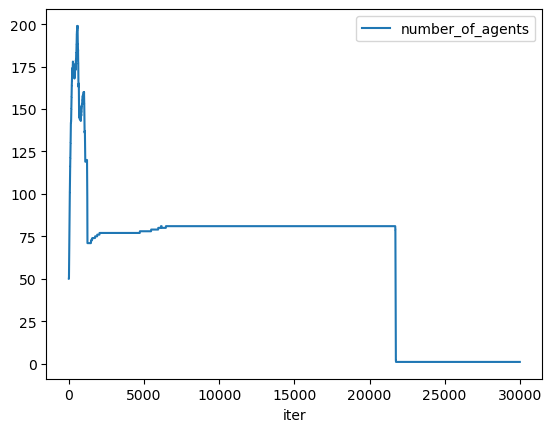

In [ ]:
df_agents.plot(x="iter", y="number_of_agents")

<Axes: xlabel='iter'>

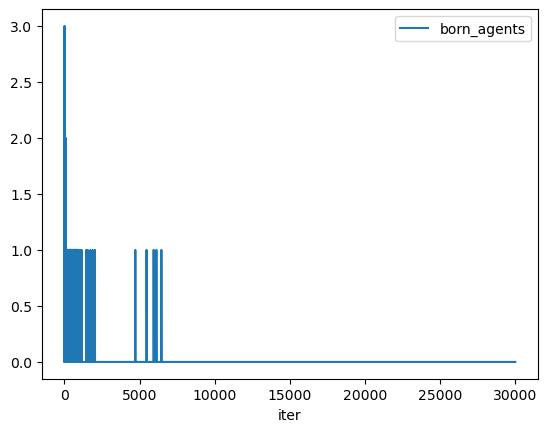

In [ ]:
df_agents.plot(x="iter", y="born_agents")

<Axes: xlabel='iter'>

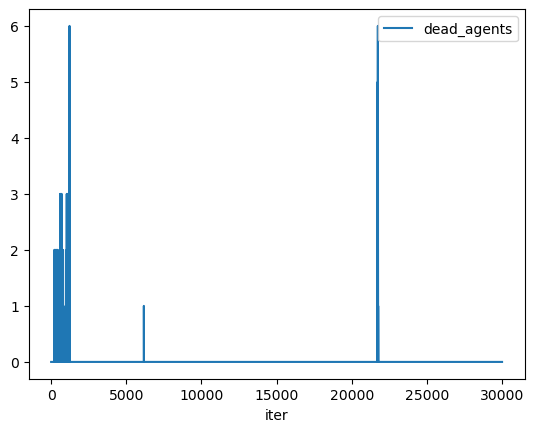

In [ ]:
df_agents.plot(x="iter", y="dead_agents")

<Axes: xlabel='iter'>

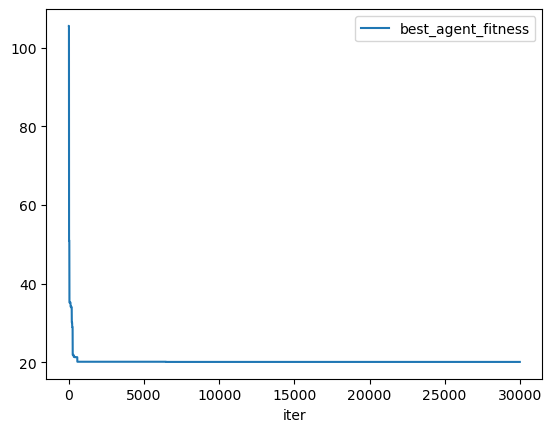

In [ ]:
df_agents.plot(x="iter", y="best_agent_fitness")

<Axes: xlabel='iter'>

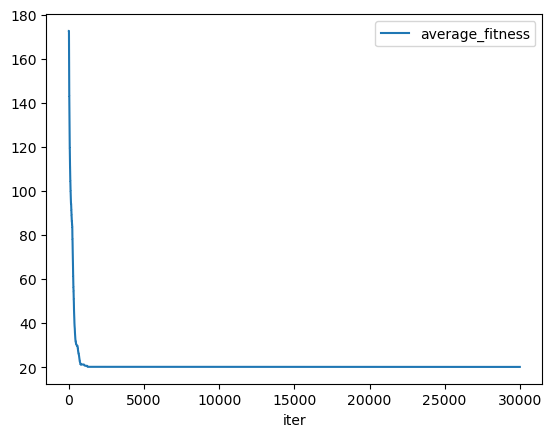

In [ ]:
df_agents.plot(x="iter", y="average_fitness")

<Axes: xlabel='iter'>

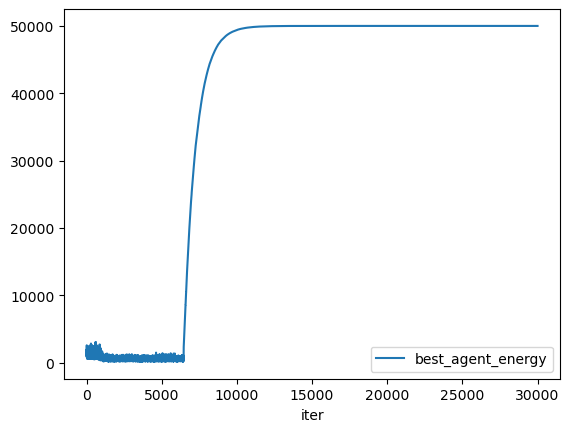

In [ ]:
df_agents.plot(x="iter", y="best_agent_energy")

<Axes: xlabel='iter'>

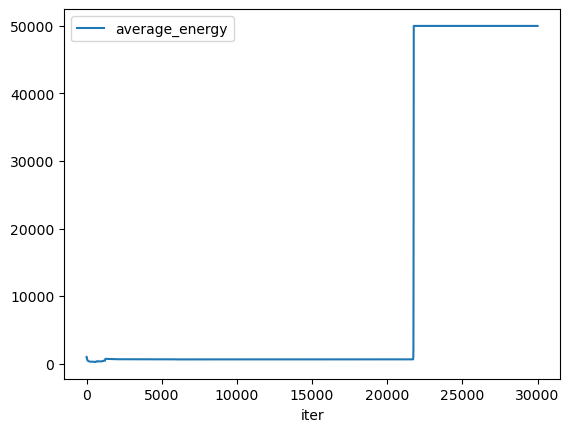

In [ ]:
df_agents.plot(x="iter", y="average_energy")

<Axes: xlabel='iter'>

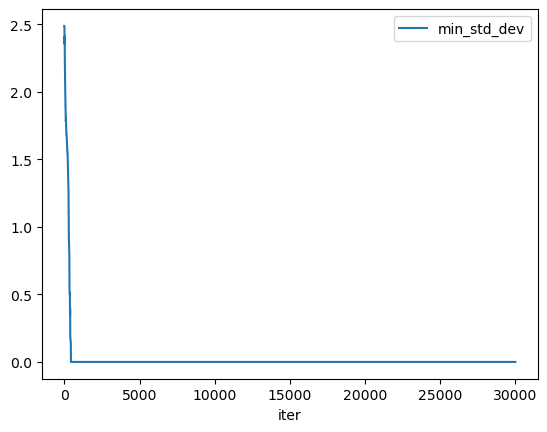

In [ ]:
df_agents.plot(x="iter", y="min_std_dev")

<Axes: xlabel='iter'>

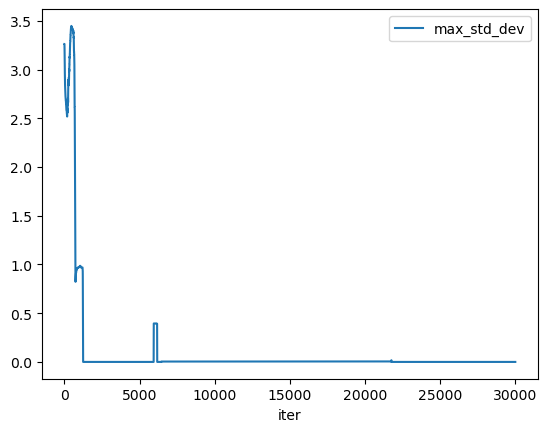

In [ ]:
df_agents.plot(x="iter", y="max_std_dev")

In [ ]:
df_agents_energy = pd.DataFrame(pandas_data_agents_energy) 
display(df_agents_energy)

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,iter
0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1,900.0,900.0,900.0,900.0,900.0,1100.0,900.0,900.0,900.0,900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1
2,810.0,810.0,810.0,810.0,810.0,990.0,810.0,810.0,810.0,810.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2
3,729.0,729.0,729.0,729.0,729.0,891.0,729.0,891.0,729.0,909.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3
4,656.1,656.1,656.1,656.1,656.1,801.9,656.1,980.1,656.1,818.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49999.991646,29995
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49999.991646,29996
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49999.991646,29997
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49999.991646,29998


<Axes: xlabel='iter'>

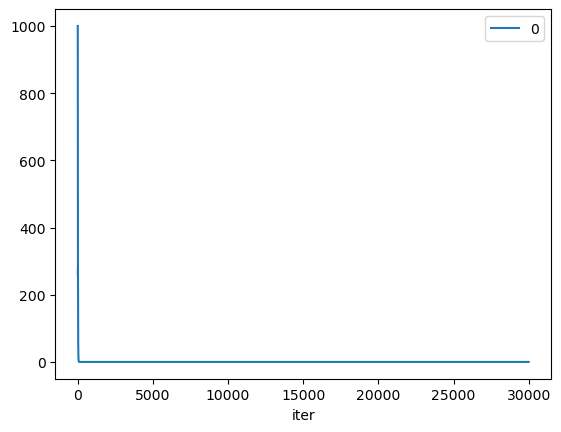

In [ ]:
df_agents_energy.plot(x='iter', y="0")

<Axes: xlabel='iter'>

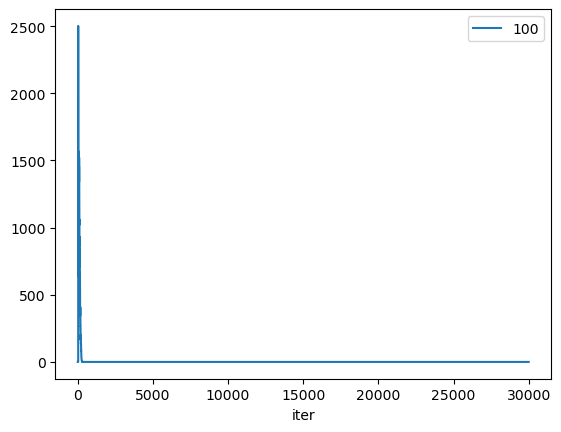

In [ ]:
df_agents_energy.plot(x='iter', y="100")

([-1.1510727876277498, 0.6908285344466991, 0.2738779032817975, 0.6533835682192581, -1.1009603572575726, -3.1878860159821354, 0.7770164430456443, -0.8986871790873193, -0.07203600919024744, 0.12389109697427081, -0.4551878803616436, -0.37685890640572417, -0.4640642017019818, -0.10401009047131149, -0.24773084415599023, -0.5110348385832948, 0.500243121793599, -1.951798410320447, -0.1711475837078016, 0.29949747668909854], 2031, 20.187464118605877)


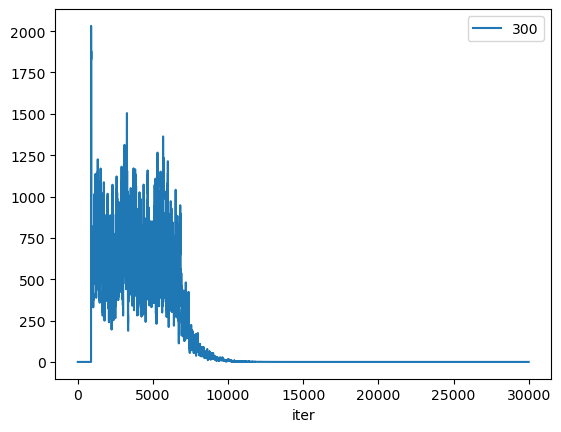

In [ ]:
df_agents_energy.plot(x='iter', y="300")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(300)))

([-1.1510727876277498, 0.6908285344466991, 0.2738779032817975, 0.6533835682192581, -1.1009603572575726, -3.1878860159821354, 0.7770164430456443, -0.8986871790873193, -0.07203600919024744, 0.12389109697427081, -0.4551878803616436, -0.37685890640572417, -0.4640642017019818, -0.10401009047131149, -0.24773084415599023, -0.5110348385832948, 0.500243121793599, -1.951798410320447, -0.1711475837078016, 0.29949747668909854], 1926, 20.187464118605877)


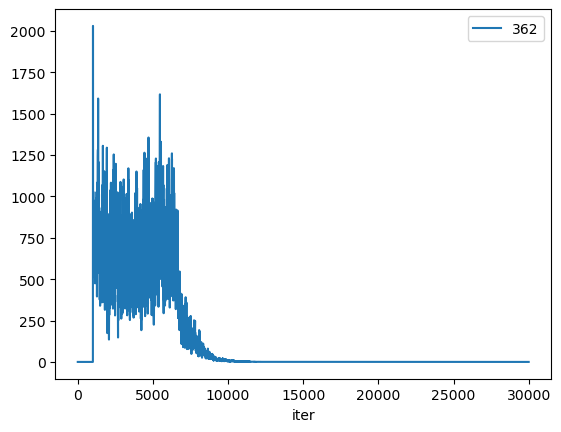

In [ ]:
df_agents_energy.plot(x='iter', y="362")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(362)))

([-1.1510727876277498, 0.6908285344466991, 0.2738779032817975, 0.6533835682192581, -1.1009603572575726, -3.1878860159821354, 0.7770164430456443, -0.8986871790873193, -0.07203600919024744, 0.12389109697427081, -0.4551878803616436, -0.37685890640572417, -0.4640642017019818, -0.10401009047131149, -0.24773084415599023, -0.5110348385832948, 0.500243121793599, -1.951798410320447, -0.1711475837078016, 0.29949747668909854], 1813, 20.187464118605877)


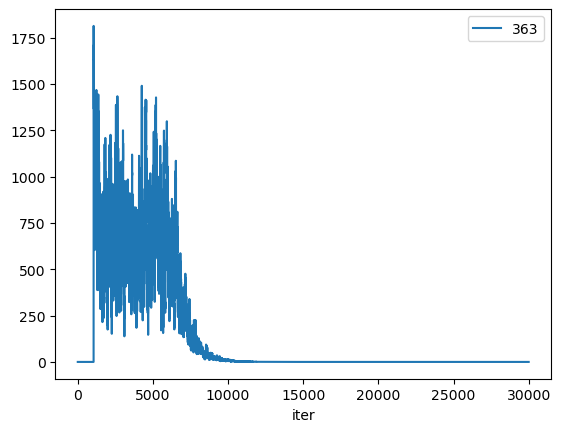

In [ ]:
df_agents_energy.plot(x='iter', y="363")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(363)))

([-1.1510727876277498, 0.6908285344466991, 0.2738779032817975, 0.6533835682192581, -1.1009603572575726, -3.1878860159821354, 0.7770164430456443, -0.8986871790873193, -0.07203600919024744, 0.12389109697427081, -0.4551878803616436, -0.37685890640572417, -0.4640642017019818, -0.10401009047131149, -0.24773084415599023, -0.5110348385832948, 0.500243121793599, -1.951798410320447, -0.1711475837078016, 0.29949747668909854], 2124, 20.187464118605877)


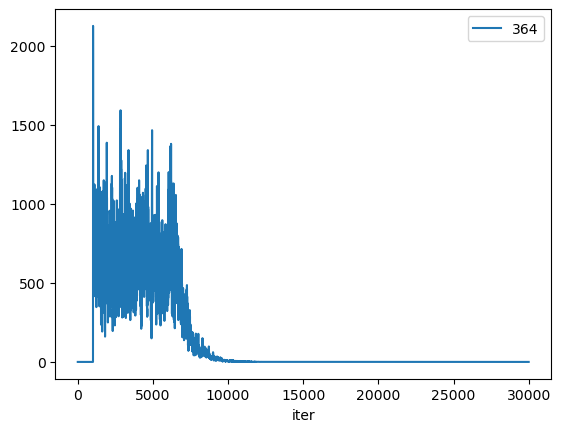

In [ ]:
df_agents_energy.plot(x='iter', y="364")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(364)))

([-1.15, 0.69, 0.27, 0.62, -1.1, -3.19, 0.78, -0.9, -0.07, 0.12, -0.46, -0.38, -0.46, -0.1, -0.25, -0.51, 0.5, -1.95, -0.17, 0.3], 1827, 20.143505985603674)


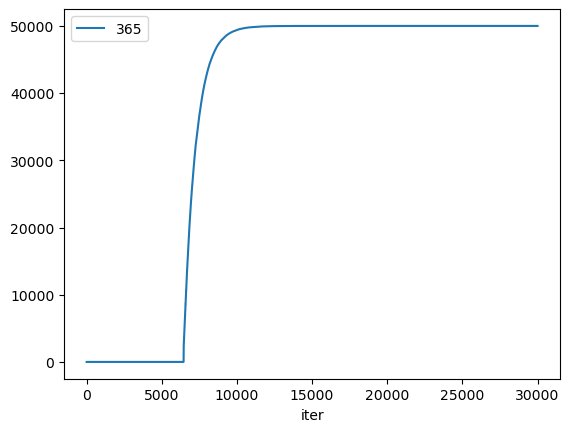

In [ ]:
df_agents_energy.plot(x='iter', y="365")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(365)))

<Axes: xlabel='iter'>

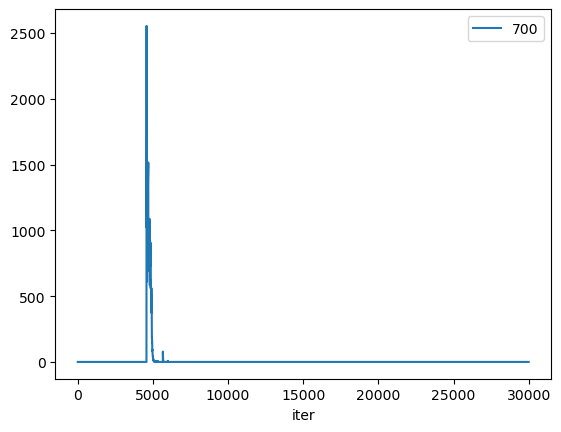

In [ ]:
df_agents_energy.plot(x='iter', y="700")

<Axes: xlabel='iter'>

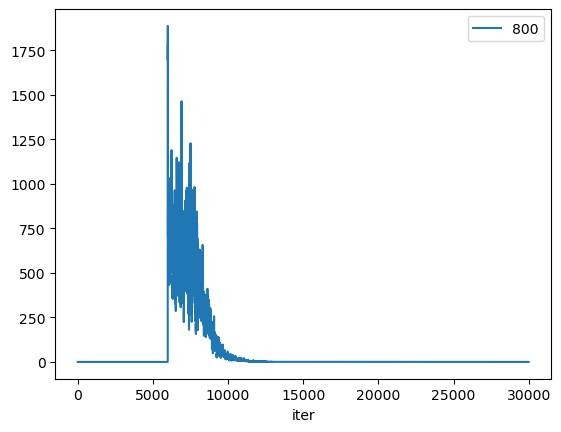

In [ ]:
df_agents_energy.plot(x='iter', y="800")

<Axes: xlabel='iter'>

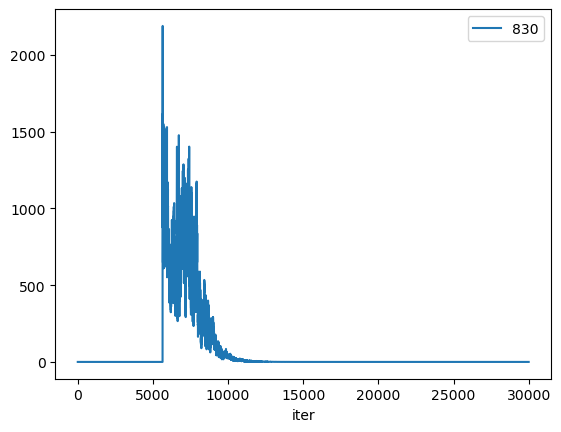

In [ ]:
df_agents_energy.plot(x='iter', y="830")

NameError: name 'get_agent_data_with_id' is not defined

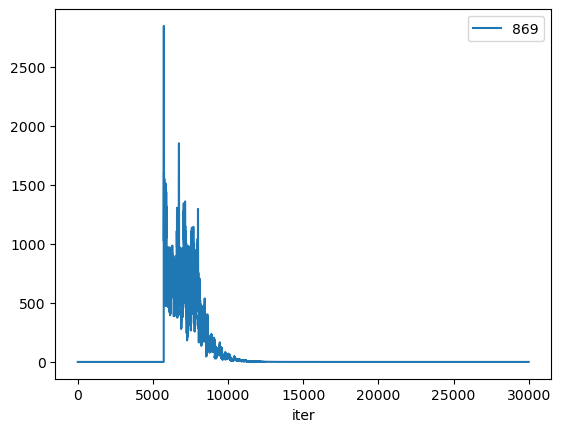

In [ ]:
df_agents_energy.plot(x='iter', y="869")
print(get_agent_data_with_id(get_agent_id_from_pd_energy(869)))



<Axes: xlabel='iter'>

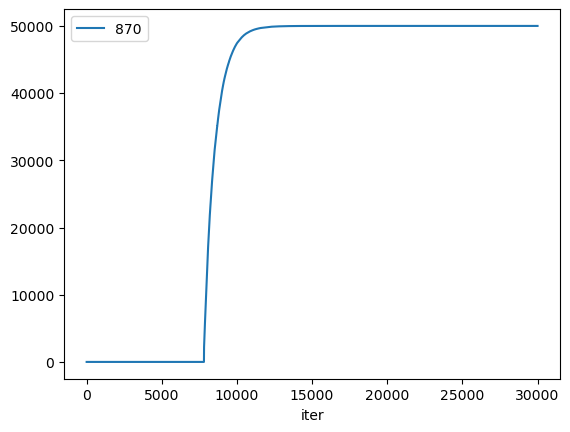

In [ ]:
df_agents_energy.plot(x='iter', y="870")